# Исследование влияния размерности латентного пространства (latent_dim)

In [1]:
import yaml
import subprocess
import os
import pandas as pd
import matplotlib.pyplot as plt
import traceback
import numpy as np
import copy
import sys
%matplotlib widget

# --- Настройка путей относительно папки notebooks/ ---
project_root = os.path.abspath('..') # Путь к корневой папке проекта
src_path = os.path.join(project_root, 'src')
# Добавляем src в путь для импорта
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Импортируем функцию оценки
try:
    from evaluate import evaluate as run_evaluation_func
except ImportError as e:
    print(f"Не удалось импортировать 'evaluate' из {src_path}.")
    print("Убедитесь, что структура проекта верна и ноутбук находится в папке notebooks/.")
    print(e)
    raise

## 1. Конфигурация Эксперимента

In [3]:
latent_dims_to_test = [8, 16, 32, 64, 128, 256]
# Путь к конфигу относительно ноутбука
config_path = os.path.join(project_root, 'config.yaml')
# Путь к скрипту обучения относительно ноутбука
train_script_path = 'src/train.py'

## 2. Загрузка и Модификация Конфигурации

In [4]:
try:
    with open(config_path, 'r') as f:
        base_config = yaml.safe_load(f)
    print("Базовая конфигурация загружена.")
except Exception as e:
    print(f"Ошибка загрузки {config_path}: {e}")
    raise e

# Проверка ключей... (остается как есть)
required_keys = ['data_dir', 'batch_size', 'latent_dim_lossy', 'latent_dim_lossless',
                 'learning_rate', 'num_epochs', 'model_save_dir', 'results_save_dir']
for key in required_keys:
    if key not in base_config:
        raise KeyError(f"Ключ '{key}' отсутствует в базовой конфигурации {config_path}")

# Важно: Проверим, что пути в config.yaml указаны относительно корня проекта
print("\nПроверка путей в config.yaml (должны быть относительны корня проекта):")
print(f"  data_dir: {base_config.get('data_dir')}")
print(f"  model_save_dir: {base_config.get('model_save_dir')}")
print(f"  results_save_dir: {base_config.get('results_save_dir')}")
# Если пути неправильные, их нужно исправить в самом файле config.yaml (например, "./data", "./models")

Базовая конфигурация загружена.

Проверка путей в config.yaml (должны быть относительны корня проекта):
  data_dir: data
  model_save_dir: models
  results_save_dir: reports/figures


## 3. Функция для запуска и парсинга

In [5]:
def run_lossy_experiment(latent_dim, base_config, train_script_path, project_root_dir, train = True):
    """
    Запускает обучение через subprocess и оценку через импортированную функцию.
    Возвращает словарь с метриками.
    """
    print(f"\n--- Запуск эксперимента для latent_dim = {latent_dim} ---")

    # 1. Модификация и сохранение временной конфигурации В КОРНЕ ПРОЕКТА
    current_config = copy.deepcopy(base_config)
    current_config['model_type'] = 'lossy'
    current_config['latent_dim_lossy'] = latent_dim
    # Путь к временному конфигу относительно корня проекта
    temp_config_filename = f'temp_config_ld{latent_dim}.yaml'
    temp_config_path_abs = os.path.join(project_root_dir, temp_config_filename)
    try:
        with open(temp_config_path_abs, 'w') as f:
            yaml.dump(current_config, f, default_flow_style=False)
    except Exception as e:
        print(f"Ошибка сохранения временной конфигурации {temp_config_path_abs}: {e}")
        return None

    results = {'latent_dim': latent_dim, 'mse_pixel': None, 'compression_ratio': None, 'train_success': False, 'eval_success': False, 'eval_error': None}

    # 2. Запуск обучения (через subprocess)
    print(f"Запуск обучения ({train_script_path})...")
    try:
        if train:
            # Запускаем python из КОРНЕВОЙ директории проекта, передавая путь к скрипту и конфигу
            # Используем относительный путь к временному конфигу из корня
            cmd = ['python', train_script_path, '--config', temp_config_filename]
            # Указываем рабочую директорию для subprocess = корень проекта
            process_train = subprocess.run(cmd, check=True, capture_output=True, text=True,
                                        encoding='utf-8', cwd=project_root_dir)
            print("Обучение успешно завершено.")
        else:
            print("Модель уже обучена.")
        results['train_success'] = True
    except subprocess.CalledProcessError as e:
        print(f"Ошибка во время обучения (latent_dim={latent_dim}):")
        print(f"Stderr: {e.stderr[-1000:]}")
        if os.path.exists(temp_config_path_abs): os.remove(temp_config_path_abs)
        return results
    except FileNotFoundError:
         print(f"Ошибка: python или скрипт {train_script_path} не найден."); return None
    except Exception as e:
        print(f"Непредвиденная ошибка при запуске обучения: {e}")
        if os.path.exists(temp_config_path_abs): os.remove(temp_config_path_abs)
        return results
    
    print(f"Запуск оценки (через импорт)...")
    try:
        # Вызываем функцию evaluate, передавая АБСОЛЮТНЫЙ путь к временному конфигу
        # (или относительный из корня, если функция evaluate его ожидает)
        # Поскольку evaluate импортирована, она будет работать из текущей директории (notebooks/)
        # но ей нужен правильный путь к конфигу. Передадим абсолютный.
        evaluation_dict = run_evaluation_func(temp_config_path_abs, project_root=project_root_dir)

        if evaluation_dict["success"]:
            print("Оценка успешно завершена.")
            results['model_type'] = 'lossy'
            results['eval_success'] = True
            results['mse_pixel'] = evaluation_dict['mse_per_pixel']
            results['compression_ratio'] = evaluation_dict['compression_ratio']
            print(f"  Получено MSE (пиксель): {results['mse_pixel']}")
            print(f"  Получен Коэффициент сжатия: {results['compression_ratio']}")
        else:
            print(f"Функция оценки завершилась с ошибкой: {evaluation_dict['error_message']}")
            results['eval_error'] = evaluation_dict['error_message']
    except Exception as e:
        print(f"Непредвиденная ошибка при вызове функции оценки: {e}")
        traceback.print_exc() # Печать полного traceback
        results['eval_error'] = str(e)

    # Удаляем временный файл конфигурации
    if os.path.exists(temp_config_path_abs):
        try:
            os.remove(temp_config_path_abs)
        except Exception as e:
            print(f"Не удалось удалить временный файл {temp_config_path_abs}: {e}")

    return results

## 4. Проведение Экспериментов

In [6]:
all_results = []

# --- 4.1 Эксперименты для Lossy моделей ---
print("--- НАЧАЛО ЭКСПЕРИМЕНТОВ ДЛЯ LOSSY МОДЕЛЕЙ ---")
for dim in latent_dims_to_test:
    experiment_result = run_lossy_experiment(dim, base_config, train_script_path, project_root, train=True)
    if experiment_result:
        all_results.append(experiment_result)
    else:
        print(f"Эксперимент для lossy latent_dim={dim} не удался.")

--- НАЧАЛО ЭКСПЕРИМЕНТОВ ДЛЯ LOSSY МОДЕЛЕЙ ---

--- Запуск эксперимента для latent_dim = 8 ---
Запуск обучения (src/train.py)...
Обучение успешно завершено.
Запуск оценки (через импорт)...
(evaluate.py) Используется переданный корень проекта: c:\Users\Владислав\Desktop\Семантическое кодирование\3\autoencoder-compression


Оценка успешно завершена.
  Получено MSE (пиксель): 0.01705209122871866
  Получен Коэффициент сжатия: 98.0

--- Запуск эксперимента для latent_dim = 16 ---
Запуск обучения (src/train.py)...
Обучение успешно завершено.
Запуск оценки (через импорт)...
(evaluate.py) Используется переданный корень проекта: c:\Users\Владислав\Desktop\Семантическое кодирование\3\autoencoder-compression


Оценка успешно завершена.
  Получено MSE (пиксель): 0.008304955331646666
  Получен Коэффициент сжатия: 49.0

--- Запуск эксперимента для latent_dim = 32 ---
Запуск обучения (src/train.py)...
Обучение успешно завершено.
Запуск оценки (через импорт)...
(evaluate.py) Используется переданный корень проекта: c:\Users\Владислав\Desktop\Семантическое кодирование\3\autoencoder-compression


Оценка успешно завершена.
  Получено MSE (пиксель): 0.003984292808844119
  Получен Коэффициент сжатия: 24.5

--- Запуск эксперимента для latent_dim = 64 ---
Запуск обучения (src/train.py)...
Обучение успешно завершено.
Запуск оценки (через импорт)...
(evaluate.py) Используется переданный корень проекта: c:\Users\Владислав\Desktop\Семантическое кодирование\3\autoencoder-compression


Оценка успешно завершена.
  Получено MSE (пиксель): 0.001979962123170191
  Получен Коэффициент сжатия: 12.25

--- Запуск эксперимента для latent_dim = 128 ---
Запуск обучения (src/train.py)...
Обучение успешно завершено.
Запуск оценки (через импорт)...
(evaluate.py) Используется переданный корень проекта: c:\Users\Владислав\Desktop\Семантическое кодирование\3\autoencoder-compression


Оценка успешно завершена.
  Получено MSE (пиксель): 0.0010006593828298608
  Получен Коэффициент сжатия: 6.125

--- Запуск эксперимента для latent_dim = 256 ---
Запуск обучения (src/train.py)...
Обучение успешно завершено.
Запуск оценки (через импорт)...
(evaluate.py) Используется переданный корень проекта: c:\Users\Владислав\Desktop\Семантическое кодирование\3\autoencoder-compression


Оценка успешно завершена.
  Получено MSE (пиксель): 0.0007899711607670298
  Получен Коэффициент сжатия: 3.0625


In [7]:
# --- 4.2 Оценка для Lossless модели (по конфигу) ---
print("\n--- ОЦЕНКА LOSSLESS МОДЕЛИ ---")
# Убедимся, что lossless модель уже обучена (этот скрипт ее не обучает)
lossless_config = copy.deepcopy(base_config)
lossless_config['model_type'] = 'lossless'
# Используем отдельный временный конфиг для lossless
temp_lossless_config_filename = 'temp_config_lossless.yaml'
temp_lossless_config_path_abs = os.path.join(project_root, temp_lossless_config_filename)
try:
    with open(temp_lossless_config_path_abs, 'w') as f:
        yaml.dump(lossless_config, f, default_flow_style=False)

    lossless_results = {'model_type': 'lossless', 'latent_dim': base_config['latent_dim_lossless'], 'mse_pixel': None, 'compression_ratio': None, 'train_success': None, 'eval_success': False, 'eval_error': None}
    print(f"Запуск оценки lossless (ld={lossless_results['latent_dim']}) через импорт...")
    try:
        evaluation_dict = run_evaluation_func(temp_lossless_config_path_abs, project_root=project_root)
        if evaluation_dict["success"]:
            lossless_results['eval_success'] = True
            lossless_results['mse_pixel'] = evaluation_dict['mse_per_pixel']
            # Коэффициент сжатия для lossless не имеет смысла или равен ~1
            lossless_results['compression_ratio'] = 1 # Берем если есть
            print("Оценка lossless успешно завершена.")
        else:
            lossless_results['eval_error'] = evaluation_dict['error_message']
            print(f"Ошибка оценки lossless: {evaluation_dict['error_message']}")
        all_results.append(lossless_results) # Добавляем в общие результаты
    except Exception as e:
        print(f"Непредвиденная ошибка оценки lossless: {e}"); traceback.print_exc()
        lossless_results['eval_error'] = str(e)
        all_results.append(lossless_results) # Добавляем даже если была ошибка

    # Удаляем временный конфиг lossless
    if os.path.exists(temp_lossless_config_path_abs):
        try: os.remove(temp_lossless_config_path_abs)
        except Exception as e: print(f"Не удалось удалить {temp_lossless_config_path_abs}: {e}")

except Exception as e:
    print(f"Общая ошибка при обработке lossless модели: {e}")


--- ОЦЕНКА LOSSLESS МОДЕЛИ ---
Запуск оценки lossless (ld=784) через импорт...
(evaluate.py) Используется переданный корень проекта: c:\Users\Владислав\Desktop\Семантическое кодирование\3\autoencoder-compression


Оценка lossless успешно завершена.


## 5. Анализ Результатов


--- Сводная Таблица Результатов ---


,model_type,latent_dim,train_success,eval_success,mse_pixel,compression_ratio,eval_error
0,lossy,8,True,True,0.017052,98.0000,None
1,lossy,16,True,True,0.008305,49.0000,None
2,lossy,32,True,True,0.003984,24.5000,None
3,lossy,64,True,True,0.001980,12.2500,None
4,lossy,128,True,True,0.001001,6.1250,None
5,lossy,256,True,True,0.000790,3.0625,None
6,lossless,784,None,True,0.000675,1.0000,None



--- График зависимости MSE и Коэффициента Сжатия (Все модели) ---


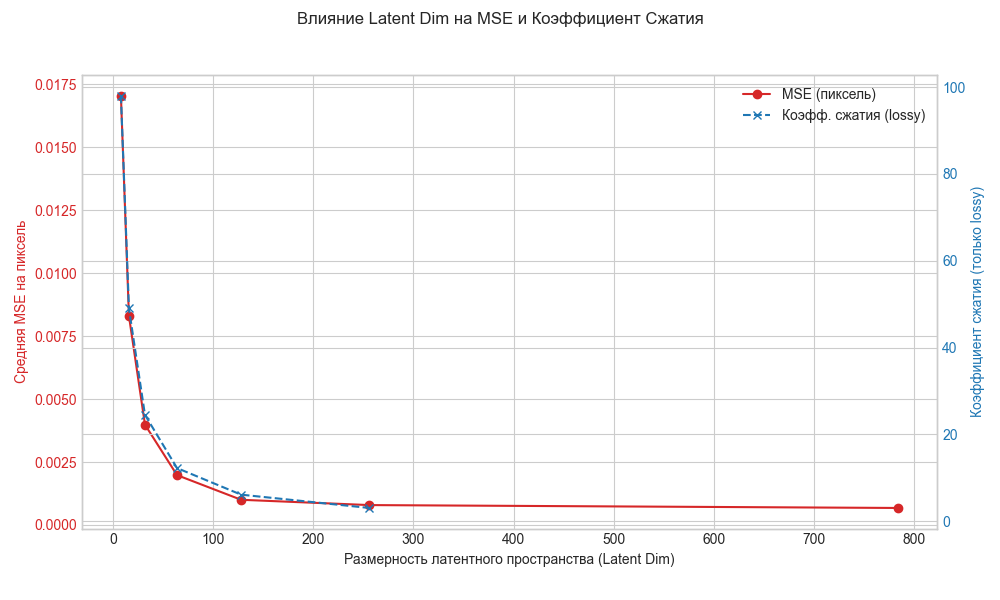

In [8]:
if not all_results: print("\nНет результатов для анализа.")
else:
    results_df = pd.DataFrame(all_results)
    print("\n--- Сводная Таблица Результатов ---")
    # Отображаем все колонки, включая model_type
    display(results_df[['model_type', 'latent_dim', 'train_success', 'eval_success', 'mse_pixel', 'compression_ratio', 'eval_error']])

# ## 6. Визуализация Зависимостей

    # Фильтруем только УСПЕШНЫЕ запуски оценки для графика
    plot_data_all = results_df[results_df['eval_success'] == True].copy()
    plot_data_all = plot_data_all.dropna(subset=['mse_pixel']) # Оставляем только те, где есть MSE

    if not plot_data_all.empty:
        # Преобразуем типы
        plot_data_all['latent_dim'] = pd.to_numeric(plot_data_all['latent_dim'])
        plot_data_all['mse_pixel'] = pd.to_numeric(plot_data_all['mse_pixel'])
        plot_data_all['compression_ratio'] = pd.to_numeric(plot_data_all['compression_ratio']) # Может содержать NaN для lossless
        # Сортируем по latent_dim для корректной отрисовки линий
        plot_data_all = plot_data_all.sort_values(by='latent_dim')

        print("\n--- График зависимости MSE и Коэффициента Сжатия (Все модели) ---")
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax1 = plt.subplots(figsize=(10, 6))

        # Ось Y1: MSE (для всех моделей)
        color = 'tab:red'
        ax1.set_xlabel('Размерность латентного пространства (Latent Dim)')
        ax1.set_ylabel('Средняя MSE на пиксель', color=color)
        # Строим MSE по всем точкам
        ax1.plot(plot_data_all['latent_dim'], plot_data_all['mse_pixel'], color=color, marker='o', linestyle='-', label='MSE (пиксель)')
        ax1.tick_params(axis='y', labelcolor=color)
        # ax1.set_yscale('log') # Можно использовать лог. шкалу

        # Ось Y2: Коэффициент сжатия (только для lossy)
        # Отдельно фильтруем данные ТОЛЬКО для линии коэффициента сжатия
        lossy_plot_data = plot_data_all[plot_data_all['model_type'] == 'lossy'].dropna(subset=['compression_ratio'])

        if not lossy_plot_data.empty:
            ax2 = ax1.twinx() # Создаем вторую ось
            color = 'tab:blue'
            ax2.set_ylabel('Коэффициент сжатия (только lossy)', color=color)
            # Строим линию только по lossy точкам
            ax2.plot(lossy_plot_data['latent_dim'], lossy_plot_data['compression_ratio'], color=color, marker='x', linestyle='--', label='Коэфф. сжатия (lossy)')
            ax2.tick_params(axis='y', labelcolor=color)
        else:
            print("Нет данных по коэффициенту сжатия для lossy моделей.")


        fig.suptitle('Влияние Latent Dim на MSE и Коэффициент Сжатия')
        # Добавляем легенду (может потребоваться настройка положения)
        lines, labels = ax1.get_legend_handles_labels()
        if 'ax2' in locals(): # Если вторая ось была создана
             lines2, labels2 = ax2.get_legend_handles_labels()
             ax2.legend(lines + lines2, labels + labels2, loc='best')
        else:
             ax1.legend(loc='best')

        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        print("\nНет валидных данных для построения графика.")